<center><img src="julia.svg" width="300"></center>

# <center>A modern language for quantitative computing</center>

### <center>Dr Simon Byrne - Julia Computing</center>


# What is Julia?

Julia is a modern, high-performance, dynamic programming language for technical computing.

- *modern*: based on the lessons of the past 60+ years
- *high-performance*: as fast as traditional "fast" languages (C/C++/Fortran)
- *dynamic*: "simple to use" (R/Python/Matlab)
- *technical computing*: anything involving numbers

# Why Julia?

## Solve the "two language problem"

A typical quant workflow:

1. A domain expert (analyst/scientist/engineer) writes code in a dynamic language
  - resulting code too slow for deployment
 
2. Programmer translates part or all into a compiled language
  - adds time/cost
  - potential translation errors
  - barriers to maintainenance
 
The first aim:
> Write fast, efficient code in an easy, elegant dynamic language


## Innovative design

- Multiple-dispatch
- High-performance user-defined types
- Write generic code that is also fast
- Metaprogramming for extensibility

The second aim:

> Makes it easy to do things which are difficult/impossible in other languages

## Open source

Julia is an open source language, available under the liberal MIT licence.
 - Can be deployed and redistributed freely without licencing concerns.
 - Most of the 1800 packages are also available under such terms.
  
It's easy to "look under the hood"
 - Most of Julia is written in Julia

Contributions from world experts.

Julia Computing was founded by the creators of the language to develop products that make Julia easy to use, easy to deploy and easy to scale.

# Who is using Julia?

Development originated at MIT, has been adopted extensively in industry and academia.
- 1.8 million downloads 
- \>100% annual growth

- **Aviva**: Julia is used as the computational backbone of the Solvency II model
  - Speed and scalability, and eliminates dependence on software firms and updates to proprietary code.
  
- **Conning**: Core Economic Scenario Generator product is written in Julia
  - High performance and productivity, easily scaleable.
  
- **US Federal Aviation Administration (FAA)**: Julia is used as the reference implementation of ACAS-X, the next-generation air-collistion avoidance system.
  - Clear and concise syntax aids clarity, fast enough to allow the specification to be executed directly.
  
- **Celeste project**: Machine learning astronomy project to identify galaxies and stars from 178 terabytes of images.
  - Julia became the 3rd language (after Fortran and C) to break the petaflop barrier (10<sup>15</sup> floating point operations per second).

More case studies at [www.juliacomputing.com](www.juliacomputing.com).

# Example: random walk simulation

Simulate from:
$$ X_{n+1} = X_n + \sigma Z_{n+1} $$ where $$Z_i \sim N(0,1)$$

In [141]:
function rw(n, σ)
    X = zeros(n)
    x = 0.0
    for i = 1:n
        x += σ*randn()
        X[i] = x
    end
    return X
end

rw (generic function with 1 method)

## Syntax
Similar to Python and Matlab.

Key notes:
 - explicit `end` to close blocks
 - 1-based arrays
 - indexing with square brackets (`[]`)
 - easy to use unicode symbols
   - available via LaTeX completion: `\sigma` [tab] $\longrightarrow$ `σ`

## Performance

Programmers in dynamic languages are taught to avoid `for` loops at all costs.

- Instead ecouraged to use _vectorisation_: functions which operate on whole vectors at once.

- e.g. the random walk would be written as:
```julia
cumsum(σ*randn(n))
```

Julia functions are just-in-time (JIT) compiled
 - can use `for` loops when they're most appropriate.

In [142]:
@time X = rw(100_000, 0.01); # incurs JIT overhead

  0.018286 seconds (2.31 k allocations: 897.318 KiB)


In [143]:
@time X = rw(100_000, 0.01);

  0.001510 seconds (6 allocations: 781.484 KiB)


Consider an first-order autoregressive AR(1) process:

$$ X_{n+1} = \alpha X_n + \sigma Z_{n+1} $$

Difficult to write in vectorised form, but trivial with a `for` loop.

In [144]:
function ar1(n, α, σ)
    X = zeros(n)
    x = 0.0
    for i = 1:n
        x = α*x + σ*randn()
        X[i] = x
    end
    return X
end

ar1 (generic function with 1 method)

# Types and multiple dispatch

Every object in Julia has a type

In [145]:
typeof(1.0)

Float64

In [146]:
typeof(1)

Int64

In [147]:
typeof(1//2)

Rational{Int64}

Julia makes it easy to define new types

e.g. complex numbers are defined in Julia as:
```julia
struct Complex{T<:Real} <: Number
  re::T
  im::T
end
```
- a subtype of `Number`
- has 2 fields: `re` and `im`
- parameterised by a type `T` which is a subtype of `Real`

In [148]:
typeof(1+2*im)

Complex{Int64}

In [149]:
typeof(1+2.0*im)

Complex{Float64}

In [150]:
typeof(1+1//2*im)

Complex{Rational{Int64}}

User-defined types are fast!
 - immutable types have no creation/destruction overhead

Types can extend functionality:
 - built-in `BigInt` and `BigFloat` for arbitrary precision calculations
 - Packages provide decimal floating point, fixed point, unitful quantities, quaternions.

Types can add metadata for more efficient behaviour:
 - e.g. `Diagonal`, `Triangular`, `Symmetric` matrix types

## Multiple dispatch

Julia functions are _generic_: can define different methods for different input types.

In [151]:
f(x::Float64) = "$x is a float" # "$" does string substitution
f(x::Int) = "$x is an integer"

f (generic function with 5 methods)

* `f(...) = ...` is the same as `function f(...) ... end`
* `::` is an optional *type specification*.

In [152]:
f(1.0)

"1.0 is a float"

In [153]:
f(1)

"1 is an integer"

Unlike traditional object oriented languages (C++, Python, Matlab), functions don't "belong" to a type. This allows for *multiple dispatch* on any combination of arguments.

In [154]:
f(x::Float64,y::Int) = "$x is a float, but $y is an integer"
f(x::Real,y::Real) = "$x and $y are both some sort of reals" # Real is an abstract "super" type
f(x,y) = "I don't know what $x and $y are" # fallback

f (generic function with 5 methods)

In [155]:
f(1.0,1)

"1.0 is a float, but 1 is an integer"

In [156]:
f(1,1//2)

"1 and 1//2 are both some sort of reals"

In [157]:
f("aaa",2)

"I don't know what aaa and 2 are"

Makes it possible to write generic code, but define specific methods where available.

e.g. consider the "linear solve" operator `A \ b` (solution to `Ax = b`):

| type of `A` | algorithm |
|-------------|-------------------------|
| `Diagonal{T}` | element-wise division |
| `Triangular{T}` | Gaussian elimination |
| `Symmetric{T}` | Bunch-Kaufman decomposition |
| `Matrix{T}` | LU decomposition |

which themselves use generic arithmetic operations (`+`/`*`/`/`) defined for `T`

In [158]:
A = UpperTriangular([ j // i for i=1:5, j=1:5])

5×5 UpperTriangular{Rational{Int64},Array{Rational{Int64},2}}:
 1//1  2//1  3//1  4//1  5//1
  ⋅    1//1  3//2  2//1  5//2
  ⋅     ⋅    1//1  4//3  5//3
  ⋅     ⋅     ⋅    1//1  5//4
  ⋅     ⋅     ⋅     ⋅    1//1

In [159]:
x = 1:5 # a Range object: equivalent to [1,2,3,4,5]

1:5

In [160]:
A \ x

5-element Array{Rational{Int64},1}:
 -3//1
 -5//2
 -7//3
 -9//4
  5//1

Or using high-precision floating point:

In [161]:
BigFloat.(A) \ BigFloat.(x)

5-element Array{BigFloat,1}:
 -3.000000000000000000000000000000000000000000000000000000000000000000000000000000
 -2.500000000000000000000000000000000000000000000000000000000000000000000000000069
 -2.333333333333333333333333333333333333333333333333333333333333333333333333333287
 -2.250000000000000000000000000000000000000000000000000000000000000000000000000000
  5.000000000000000000000000000000000000000000000000000000000000000000000000000000

Types are critical to Julia's performance

At the compilation stage, Julia does _type inference_: it determines the set of possible types each value can have.
 - if all values are determined to have a unique type, Julia can get performance comparable to statically compiled languages

Performance tip:
> Aim to write functions which are _type stable_: i.e. always return values of a single type

In [162]:
typemax(Int)

9223372036854775807

In [163]:
typemax(Int)+1

-9223372036854775808

If Julia promoted to `BigInt`, any integer arithmetic operations (e.g. array indexing) would incur significant overhead.

# Metaprogramming

Julia provides powerful facilities for _metaprogramming_: code that generates other code.

**Macros** operate on expressions, and are prefixed with `@`:

In [164]:
@time ar1(100_000,0.8,0.01);

  0.019664 seconds (2.41 k allocations: 902.317 KiB)


In [165]:
@macroexpand @time ar1(100_000,0.8,0.01)

quote  # util.jl, line 235:
    local #184#stats = (Base.gc_num)() # util.jl, line 236:
    local #186#elapsedtime = (Base.time_ns)() # util.jl, line 237:
    local #185#val = ar1(100000, 0.8, 0.01) # util.jl, line 238:
    #186#elapsedtime = (Base.time_ns)() - #186#elapsedtime # util.jl, line 239:
    local #187#diff = (Base.GC_Diff)((Base.gc_num)(), #184#stats) # util.jl, line 240:
    (Base.time_print)(#186#elapsedtime, #187#diff.allocd, #187#diff.total_time, (Base.gc_alloc_count)(#187#diff)) # util.jl, line 242:
    #185#val
end

They provide powerful tools to peek inside the Julia internals:

In [166]:
g(x) = x < 0.0 ? 0 : x*x # if-else ternary operator _ ? _ : _
@code_typed g(0.1) # lowering and type inference

CodeInfo(:(begin 
        unless (Base.lt_float)(x, 0.0)::Bool goto 3
        return 0
        3: 
        return (Base.mul_float)(x, x)::Float64
    end))=>Union{Float64, Int64}

In [167]:
g2(x) = x < 0.0 ? zero(x) : x*x # zero(x) returns a zero of the same type as x
@code_typed g2(0.1)

CodeInfo(:(begin 
        unless (Base.lt_float)(x, 0.0)::Bool goto 3
        return (Base.sitofp)(Float64, 0)::Float64
        3: 
        return (Base.mul_float)(x, x)::Float64
    end))=>Float64

In [168]:
@code_llvm g2(0.1)


define double @julia_g2_67338(double) #0 !dbg !5 {
top:
  %1 = fcmp uge double %0, 0.000000e+00
  br i1 %1, label %L3, label %if

if:                                               ; preds = %top
  ret double 0.000000e+00

L3:                                               ; preds = %top
  %2 = fmul double %0, %0
  ret double %2
}


In [169]:
@code_native g2(0.1)

	.section	__TEXT,__text,regular,pure_instructions
Filename: In[167]
	pushq	%rbp
	movq	%rsp, %rbp
Source line: 1
	xorps	%xmm1, %xmm1
	ucomisd	%xmm0, %xmm1
	ja	L19
	mulsd	%xmm0, %xmm0
	popq	%rbp
	retq
L19:
	xorps	%xmm0, %xmm0
	popq	%rbp
	retq
	nopl	(%rax,%rax)


# Parallelism

Out-of-the-box support for parallel computing

In [170]:
addprocs() # adds number based on CPU cores

4-element Array{Int64,1}:
 6
 7
 8
 9

In [171]:
# a simple Monte Carlo approximation to π
function findpi(n)
    inside = 0
    for i = 1:n
        x = rand()
        y = rand()
        if x^2 + y^2 <= 1
            inside += 1
        end
    end
    4*inside / n
end

findpi (generic function with 1 method)

In [172]:
@time findpi(100_000_000)

  1.447616 seconds (2.97 k allocations: 151.498 KiB)


3.14185392

In [173]:
@time findpi(100_000_000)

  0.746429 seconds (5 allocations: 176 bytes)


3.14161748

Simplest way to use is via `@parallel` macro which shards job across available workers

In [174]:
function parallel_findpi(n)
    inside = @parallel (+) for i = 1:n # (+) is the reduction operation to apply
        x = rand()
        y = rand()
        Int(x^2 + y^2 <= 1)
    end
    4*inside / n
end

parallel_findpi (generic function with 1 method)

In [175]:
@time parallel_findpi(100_000_000)

  1.250249 seconds (72.61 k allocations: 3.825 MiB)


3.14134676

In [176]:
@time parallel_findpi(100_000_000) # ~3x speedup

  0.283919 seconds (1.08 k allocations: 71.703 KiB)


3.14162312

Other parallel features:
 - Can distribute across multiple machines
 - `@sync`/`@async` for controlling synchronization
 - Parallel data structures:
   - SharedArrays
   - DistributedArrays
 - multi-threading: more lightweight, but shared state makes trickier to program

# Packages

Julia has an extensive and growing collection of 3rd party packages. See http://pkg.julialang.org/.

Typically suffixed with .jl for ease of searching (e.g. Distributions.jl)

Packages are installed with

```julia
Pkg.add("PackageName")
```
and loaded with
```julia
using PackageName
```

## Automatic differentiation

Automatic differentiation (AD) is _not_:
- Symbolic differentiation (manipulating algebraic expressions)
- Numeric differentiation (finite differencing)

Instead we propagate the gradient information via standard calculus properties (product rule, chain rule, etc.).

e.g. say we want to compute the value and derivative of

$$ (x/2 - 2)^2 $$

at $x=7$.

In [177]:
using DualNumbers

A dual number carries around an $\varepsilon$ term representing the derivative
 - similar to imaginary unit $i$, except $\varepsilon^2 = 0$

In [178]:
x = Dual(7,1) # dx/dx = 1

7 + 1ɛ

In [179]:
x/2

3.5 + 0.5ɛ

In [180]:
x/2-2

1.5 + 0.5ɛ

In [181]:
(x/2-2)^2

2.25 + 1.5ɛ

These are

1. _numerically exact_: we don't need to worry about tuning finite differencing parameters
2. _fast_ (e.g. 10% overhead per gradient, vs 100% for finite differencing).

To make this useable we need a language that supports:
- _Generic programming_: reuse same code with different data types
- _Function overloading via multiple dispatch_: to define how the gradients operate on each argument of each function and operator.
- _Efficient user-defined types_: `Dual` type is as efficient as built-in types.
- _High-performance_: otherwise why bother?

Julia makes this easy.

### Example: Greeks for an American put option

In [182]:
# 1. Cox-Ross-Rubinstein binomial model
function crr_am_put(S, K, r, σ, t, N)
    Δt = t/N
    U = exp(σ*√Δt)
    D = 1/U
    R = exp(r*Δt)
    p = (R-D)/(U-D) # P(up)
    q = (U-R)/(U-D) # P(down)
    # value at maturity, allocates buffer array
    Z = [max(0, K - S*exp((2*i-N)*σ*√Δt)) for i = 0:N]
    for n = N-1:-1:0
        for i = 0:n # recombining
            x = K - S*exp((2*i-n)*σ*√Δt)  # early exercise value
            y = (q*Z[i+1] + p*Z[i+2])/R  # future value
            Z[i+1] = max(x, y)
        end
    end
    return Z[1]
end

crr_am_put (generic function with 1 method)

In [183]:
# price
crr_am_put(100, 90, 0.05, 0.3, 180/365, 1000)

3.307679908124034

In [184]:
# price + delta
crr_am_put(Dual(100,1), 90, 0.05, 0.3, 180/365, 1000)

3.307679908124034 - 0.24947047459851995ɛ

Can do the same for higher-order greeks and LSMC-based models, see:

> "Automatic for the Greeks", Simon Byrne and Andy Greenwell, Wilmott Magazine
 https://www.wilmott.com/automatic-for-the-greeks/

More advanced techniques available in ForwardDiff.jl and ReverseDiff.jl packages.

# JuMP

JuMP (Julia for Mathematical Programming) is a package for mathematical optimization.

It provides a domain specific language (DSL) using macros to specify optimization problems.

### Example: portfolio optimisation

Consider a portfolio optimisation problem:

> Given expected returns, volatilities and correlations, what is the optimal portfolio weighting subject to certain constraints?

In [185]:
tickers = ["AAPL", "AMZN", "FB", "GOOG", "DB", "JPM", "BAC", "WFC", "XOM", "CVX"]
class   = ["tech", "tech", "tech", "tech", "bank", "bank", "bank", "bank", "oil", "oil"]

returns = [0.260,0.696,0.234,0.182,-0.262,0.336,0.300,0.27,0.27,0.210]
volatilities = [0.222,0.268,0.262,0.222,0.285,0.190,0.225,0.209,0.163,0.187]

corr = 
[1.00 0.50 0.48 0.63 0.33 0.38 0.37 0.26 0.30 0.27 ;
 0.50 1.00 0.57 0.67 0.14 0.28 0.31 0.22 0.16 0.11 ;
 0.48 0.57 1.00 0.72 0.23 0.33 0.33 0.26 0.36 0.29 ;
 0.63 0.67 0.72 1.00 0.36 0.47 0.45 0.42 0.39 0.29 ;
 0.33 0.14 0.23 0.36 1.00 0.58 0.57 0.45 0.31 0.33 ;
 0.38 0.28 0.33 0.47 0.58 1.00 0.92 0.77 0.47 0.53 ;
 0.37 0.31 0.33 0.45 0.57 0.92 1.00 0.73 0.38 0.46 ;
 0.26 0.22 0.26 0.42 0.45 0.77 0.73 1.00 0.44 0.38 ;
 0.30 0.16 0.36 0.39 0.31 0.47 0.38 0.44 1.00 0.66 ;
 0.27 0.11 0.29 0.29 0.33 0.53 0.46 0.38 0.66 1.00 ];

In [186]:
using JuMP, Ipopt, Plots
gr(); percentage(x) = @sprintf "%.0f%%" (x*100)

percentage (generic function with 1 method)

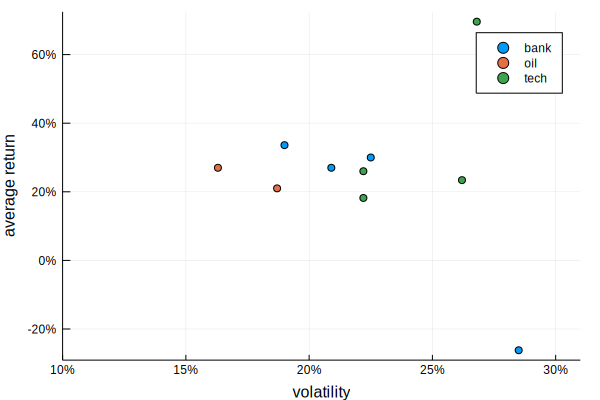

In [187]:
plot(volatilities, returns;
    group=class, markershape=:circle, line=false, 
    xlim=(0.1,0.31), xlabel="volatility", ylabel="average return",
    xformatter=percentage, yformatter=percentage)

Average return: 70%


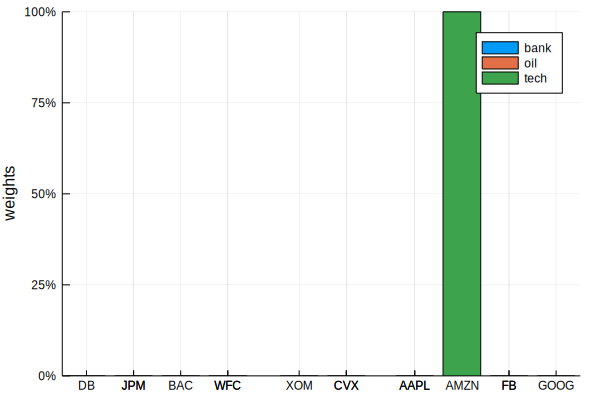

In [188]:
m = Model(solver=IpoptSolver(print_level=0))
@variable(m, weights[1:10] >= 0)  # weights must be >= 0
@constraint(m, sum(weights) == 1) # 
@objective(m, Max, dot(weights, returns))
solve(m)

println("Average return: $(percentage(getobjectivevalue(m)))")
plot(tickers, getvalue(weights); 
    linetype=:bar, group=class, yformatter=percentage, ylabel="weights")

Restrict the portfolio volatility to be at most 20%.

Average return: 57%


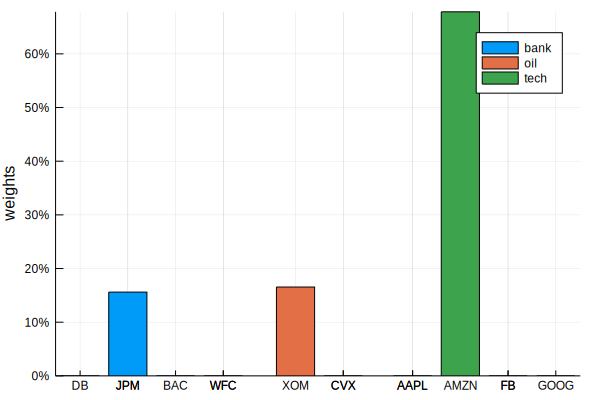

In [189]:
Σ = Diagonal(volatilities) * corr * Diagonal(volatilities) # covariance matrix
@constraint(m, dot(weights, Σ * weights) <= 0.2^2)
solve(m)

println("Average return: $(percentage(getobjectivevalue(m)))")
plot(tickers, getvalue(weights); 
    linetype=:bar, group=class, yformatter=percentage, ylabel="weights")

Restrict the weights of any one stock to be at most 25% of the portfolio:

Average return: 40%


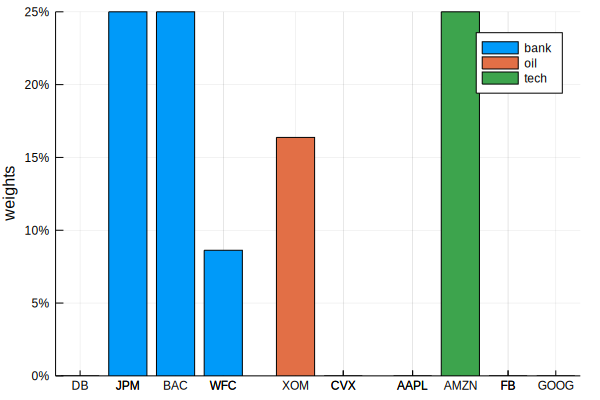

In [190]:
@constraint(m, weights .<= 0.25)
solve(m)
println("Average return: $(percentage(getobjectivevalue(m)))")
plot(tickers, getvalue(weights); 
    linetype=:bar, group=class, yformatter=percentage, ylabel="weights")

Limit each industry to be at most 40%.

Average return: 40%


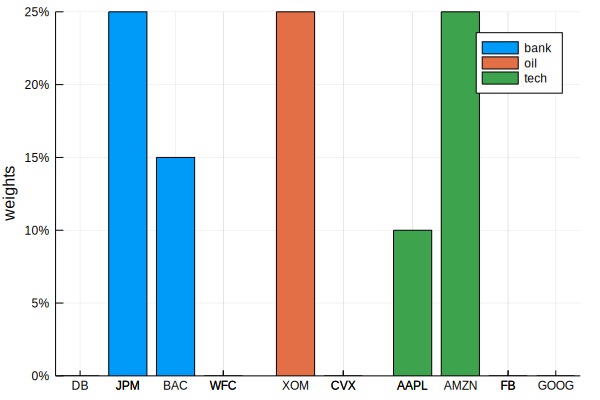

In [191]:
for c in ["tech","bank","oil"]
    @constraint(m, sum(weights[class .== c]) <= 0.4)
end
solve(m)
println("Average return: $(percentage(getobjectivevalue(m)))")
plot(tickers, getvalue(weights); 
    linetype=:bar, group=class, yformatter=percentage, ylabel="weights")

# Interoperability

Julia makes it easy to interact with other languages and tools.

## C

Julia has a simple built-in interface for calling C libary functions:

In [192]:
ccall(("pow","libm"),Cdouble,(Cdouble,Cdouble),10.0,3.0)

1000.0

Other low-level functions are similarly straightforward:
* Julia structs match layout of C structs
 - can be passed directly
* `cfunction` for making C-compatible function pointers to Julia methods
 - for implementing callbacks

Combined with metaprogramming (for generating such statements) this makes it very easy to interface with existing libraries. 

## PyCall.jl

The **PyCall.jl** package allows calling Python from Julia.

In [193]:
using PyCall

In [194]:
py"[i+3 for i in range(4)]" 

4-element Array{Int64,1}:
 3
 4
 5
 6

The `@pyimport` macro automatically loads the objects from a Python module into a Julia module:

In [195]:
@pyimport math

In [196]:
math.sin

PyObject <built-in function sin>

In [197]:
math.sin(0.2)

0.19866933079506122

As NumPy arrays use the same memory layout, they can be converted directly to the corresponding Julia array:

In [198]:
@pyimport numpy as np
np.arange(1.0,20.0,3.0)

7-element Array{Float64,1}:
  1.0
  4.0
  7.0
 10.0
 13.0
 16.0
 19.0

We can even pass Julia functions as arguments to Python functions:

In [199]:
@pyimport scipy.optimize as so
so.newton(x -> cos(x) - x, 1)

0.7390851332151607

Similar packages for other languages, including
 - R: RCall.jl
 - Java: JavaCall.jl
 - C++: CxxWrap.jl and C++.jl

# GPU computing

```julia
using CuArrays
X = randn(1_000_000)
cX = cu(X) # creates a CuArray on GPU
```
A `CuArray` acts like an ordinary Julia array, but is stored on the GPU. Can be used with ordinary Julia code.

GPUs have much more limited functionality than CPUs
 - element-wise or reduction operations are fast
 - branches or arbitrary indexing will fall back on slower CPU routines
   - overhead from copying memory between CPU and GPU
 
Can also write 

### Example: log-sum-exp function

$$ \log\left( \sum_{i=1}^n \exp X_i \right) $$

avoiding intermediate overflow/underflow if $X_i$ too large/small.

In [200]:
function logsumexp(X)
    u = maximum(X)
    u + log(sum(x -> exp(x-u), X))
end

logsumexp (generic function with 1 method)

Array of 1 million elements:
 - 0.03 seconds on CPU
 - 0.00035 seconds on GPU
 - 80x speedup

# Machine Learning and AI

Traditional languages struggle the with demands of modern ML: 
 - Support hardware accelerators (GPUs, TPUs, Xeon Phi, etc.)
 - Parallelization (Multi-threading, Multi-GPU, Distributed)
 - Automatic Differentiation
 - Optimization (Placement, Memory Use, Low overhead) 
 - Ease of programming (Math notation, Debuggers, Libraries)
 - Ease of deployment (Cloud, Phones, Embedded)

Lead to the rise of "frameworks" (TensorFlow, PyTorch, etc.), which themselves are becoming full programming languages (branching, loops, recursion)
 - cumbersome: accessible via another language (Python, C++)
 - require their own libraries for import, manipulation, data processing
 
e.g. typical PyTorch code (https://github.com/pytorch/examples/blob/master/vae/main.py):
```python
std = torch.exp(0.5*logvar)
eps = torch.randn_like(std)
return eps.mul(std).add_(mu)
```
just to write
$$ \mu + \exp(\text{log}\sigma / 2) z_i $$

# Flux: a pure-Julia ML framework

<center><img src="flux.png"></center>


```julia
model = Chain(
  Dense(768, 128),
  LSTM(128, 256)
  LSTM(256, 128)
  Dense(128, 10),
  softmax)

loss(x, y) = crossentropy(model(x), y)

Flux.train!(loss, data, ADAM(...))
```

- Concise, clear syntax
  - It looks like the mathematics!
- Leverages Julia AD and GPU tooling
- Easily extensible,
  - Layers can incorporate other Julia code: e.g. diffeq solvers, optimization

# The future of Julia

We are about to release version 1.0
 - language will be backwards compatible from this point forward
 
Focusing on features that will make Julia easier to deploy:
 - Binary executables of Julia programs
 - JuliaRun: self-scaling Julia deployment platform
 
JuliaCon 2018: London, 7th-11th August
 - [www.juliacon.org](www.juliacon.org)